# Introduction

In this notebook, we use ***NNRepLayer*** to repair a neural network that is trained to learn a 45-degrees-counterclockwise rotation function $Rot:\mathcal{X}_o\rightarrow\mathcal{T}$ in 2D space using ***Tensorflow***. The original input space is $\mathcal{X}_o = \{\mathbf{x}^0=[x,y]\in \mathbb{R}^2\;|\; 1\leq x,y\leq4\}$. The output space $\mathcal{T}$ 
represents the set of counterclockwise rotated points in $\mathcal{X}_o$ by $\pi/4$ rad defined as 
$\mathcal{T}=\{\mathbf{y}\in\mathbb{R}^{2}\;|\;\mathbf{y}=Rot(\mathbf{x}_0)\text{ for }\mathbf{x}^0\in\mathcal{X}_o\}$. 

We repair this network to push all the outputs $\mathbf{y}$ inside a Quadrilateral defined by
\begin{align*}
    \Psi(\mathbf{y},\mathbf{x}^0)=\left\{\mathbf{y}\in\mathcal{T}\;|\;\lVert[x,y] - [2.5,2.5]\rVert_1\leq \frac{5\sqrt{2}}{4}\right\},
\end{align*}
where $\lVert\cdot\rVert_1$ denotes the $L_1$ norm and $\mathcal{X}_r=\mathcal{X}_o$. This constraint on the output can be represented in the form of $A\mathbf{y}\leq b$.
 
We perform the folowing operations here:

1. Load the neural network and repair samples.
2. Define the constraints
3. Perform the layer-wise repair.
-----------------

In [1]:
import os
from csv import writer
from datetime import datetime
import numpy as np
from affine_utils import (
    plot_dataset,
    model_eval,
    give_polys,
    give_constraints,
)
import tensorflow as tf
from shapely.affinity import scale
from tensorflow import keras
from nnreplayer.utils.options import Options
from nnreplayer.utils.utils import ConstraintsClass
from nnreplayer.repair.repair_weights_class import NNRepair
import pickle
from matplotlib import pyplot as plt
import matplotlib as mpl

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

## Initialize Repair Data set

We set the paths for reading the original model/data, and writing the repaired model.

In [3]:
direc = os.getcwd()
path_read = os.path.join(direc, "original_net")
path_write = os.path.join(direc, "repair_net")

# check directories existence
if not os.path.exists(path_read + "/model"):
    raise ImportError(f"path {path_read}/model does not exist!")
if not os.path.exists(path_write):
    os.makedirs(path_write)
    print(f"Directory: {path_write} is created!")

We load the repair data set and the original model. Here, the repair data set is similar to the training data set that includes samples with targets inside the constraint and samples with targets outside the constraint.

In [4]:
# load repair data set
if not os.path.exists(path_read + "/data/input_output_data_tc1.pickle"):
    raise ImportError(
        "path {path_read}/data/input_output_data_tc1.pickle does not exist!"
    )
with open(path_read + "/data/input_output_data_tc1.pickle", "rb") as data:
    dataset = pickle.load(data)
    
x_repair, y_repair, x_test, y_test = dataset[0], dataset[1], dataset[2], dataset[3]

# load the original model 
model_orig = tf.keras.models.load_model( os.path.join(path_read, "model"))

2022-04-30 18:05:45.295782: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We also load the polytopes representing input, output, and contraint sets, respectively. We also form the $A$ and $b$ matrices in the constraint on output in the form of $A\mathbf{y}\leq b$. 

In [5]:
# poly_input = input set, poly_output = output set, poly_const = constraint set
poly_input, poly_output, poly_const = give_polys() 

# inequality matrices
A, b = give_constraints(
    scale(poly_const, xfact=0.98, yfact=0.98, origin="center")
)

The following code snippet plots the ouput of original network. As demonstrated, some predicted targets are outside the constraint bounds (red bounds in the plot). Our goal is to impose these constraints to the trained network such that the predicted outputs lie within the contraint bounds.

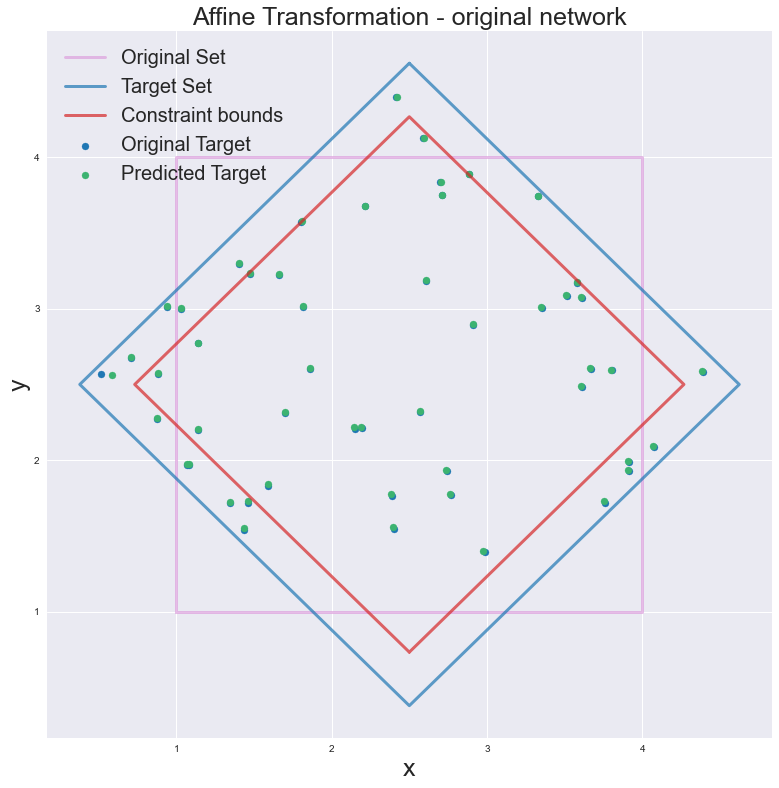

In [6]:
plt.rcParams["text.usetex"] = False
mpl.style.use("seaborn")
plt.rcParams["figure.figsize"] = (13,13)
x_poly_output_bound, y_poly_output_bound = poly_output.exterior.xy
x_poly_input_bound, y_poly_input_bound = poly_input.exterior.xy
x_poly_const_bound, y_poly_const_bound = poly_const.exterior.xy

## predicted output (training dataset)
plt.plot(
    x_poly_input_bound,
    y_poly_input_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_output_bound,
    y_poly_output_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.plot(
    x_poly_const_bound,
    y_poly_const_bound,
    color="tab:red",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Constraint bounds",
)
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    color="tab:blue",
    label="Original Target",
)
y_predict_train = model_orig.predict(x_test)
plt.scatter(
    y_predict_train[:, 0],
    y_predict_train[:, 1],
    color="mediumseagreen",
    label="Predicted Target",
)
plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(r"Affine Transformation - original network", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()

## Define the Constraints

Class `ConstraintsClass` constructs a constraint object that is inputed to NNRepLayer. While constructing a constraint object, the type of constraint should be specified. The current version of NNRepLayer supports *LMI/LME* (linear matrix inequality/equality) constraints, represented in the forms of $A\mathbf{y}\leq b$ (LMI) and $C\mathbf{y} =  d$ (LME), respectively. 

In [7]:
# input the constraint list
constraint_inside = ConstraintsClass("inside", A, b) # ConstraintsClass(A, b, C, d)
output_constraint_list = [constraint_inside]
output_constraint_list

[ConstraintsClass(constraint_type='inside', A=array([[-0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678],
        [-0.70710678, -0.70710678],
        [ 0.70710678, -0.70710678]]), B=array([[ 1.225     ],
        [ 4.76053391],
        [-2.31053391],
        [ 1.225     ]]))]

## Repairing Network

#### Creating Repair Object
To repair the network using NNRepLayer, first initiate a repair object `NNRepair` from the original model. 

In [8]:
repair_obj = NNRepair(model_orig)

#### Compiling the Repair Model
We then specify the repair parameters. Parameters are passed to the repair object (`repair_obj` here) through the arguments of `compile` method. 
Here are the non-default arguments of compile method:
1. `x_repair` and `y_repair`: repair input and target samples.
2. `layer_2_repair`: the target repair layer

Default arguments of compile method:
1. `output_constraint_list`: the list of constraints on the network's output. default = None
2. `cost`: repair loss function. default = mean squared error (mse)
3. `cost_weights`: `cost_weights[0]` corresponds to weight of min loss, `cost_weights[1]` corresponds to weight of weight bounding slack variable. default = [1., 1.]
4. `max_weight_bound`: the upper bound of weights error. default = 1.0.
5. `data_precision`: precision of rounding to decimal place for repair data set. default = 4.
6. `param_precision`: precision of rounding to decimal place for network parameters. default = 4.
7. `param_bounds`: lower and upper bounds of network parameters. default is specified based on `max_weight_bound`.
8. `output_bounds`: bounds on the value of outputs. default = (-10, 10).

In [9]:
layer_to_repair = 3    # specifying the last layer
max_weight_bound = 5   # specifying the upper bound of weights error
cost_weights = np.array([1.0, 1.0]) # cost weights
repair_obj.compile(
    x_repair,
    y_repair,
    layer_to_repair,
    output_constraint_list=output_constraint_list,
    cost_weights=cost_weights,
    max_weight_bound=max_weight_bound,
)

Activating Last layer


#### Execute Network Repair
To perform the repair, we need to specify the solver specifications through `Options` class. This class creates an object of solver specifications that is then passed to the `repair` method of `repair_obj`. `repair` method performs the network repair for the specified layer (layer 3 in this example) and returns a compiled network. The format of outputed network should be specified in `Options`. Here are the parameters that need to be specified in `Options` along their default values:
1. `gdp_formulation`: specify the method of reformulation for converting disjunctive constraint to the standard MIP models. default= "gdp.bigm". Supported options: Big-M method ("gdp.bigm"), and Hull reformulation ("gdp.hull"). For more info on the supported gdp formulations read: __[GDP reformulations](https://pyomo.readthedocs.io/en/latest/modeling_extensions/gdp/solving.html?highlight=gdp.bigm#reformulation-to-mi-n-lp)__.
2. `solver_factory`: specify the MIP solver. default = "gurobi". For the list of supported solvers read: __[Supported Solvers by Pyomo](https://pyomo.readthedocs.io/en/stable/solving_pyomo_models.html#supported-solvers)__.
3. `solver_language`: solver language. default = "python".
4. `model_output_type`: the format of returned repaired model. default = "keras". Supported options: "keras", "pytorch".
5. `optimizer_options`: optimizer options. default = {'timelimit': 200}. For more info on solver options read: __[Solver Options in Pyomo](https://pyomo.readthedocs.io/en/stable/working_models.html?highlight=optimizer%20options#sending-options-to-the-solver)__.

In [10]:
# setup directory to store optimizer log file
if not os.path.exists(path_write + "/logs"):
    os.makedirs(path_write + "/logs")

# setup directory to store the modeled MIP and parameters
if not os.path.exists(path_write + "/summary"):
    os.makedirs(path_write + "/summary")

# setup directory to store the repaired model
if not os.path.exists(path_write):
    os.makedirs(path_write + f"/model_layer_{layer_to_repair}")

# specify options
options = Options(
    "gdp.bigm",
    "gurobi",
    "python",
    "keras",
    {
        "timelimit": 3600,
        "mipgap": 0.001,
        "mipfocus": 2,
        "improvestarttime": 3300,
        "logfile": path_write
        + f"/logs/opt_log_layer{layer_to_repair}.log",
    },
)

# repair the network
out_model = repair_obj.repair(options)

# store the modeled MIP and parameters
repair_obj.summary(direc=path_write + "/summary")

# store the repaired model
keras.models.save_model(
    out_model,
    path_write + f"/model_layer_{layer_to_repair}",
    overwrite=True,
    include_optimizer=False,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.001
Set parameter MIPFocus to value 2
Set parameter ImproveStartTime to value 3300
Set parameter LogFile to value "/Users/keyvanmajd/Documents/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/repair_net/logs/opt_log_layer3.log"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1424 rows, 613 columns and 4645 nonzeros
Model fingerprint: 0x3ac33f82
Model has 601 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-02, 4e+00]
  Objective range  [5e-03, 4e-02]
  QObjective range [1e-02, 2e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [4e-02, 5e+00]
Presolve removed 400 rows and 0 columns
Presolve time: 0.02s
Presolved: 1024 rows, 1013 columns, 4245 nonzeros
Presolved model has 601 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 12
 AA' NZ     : 3

2022-04-30 18:05:47.884090: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/keyvanmajd/Documents/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/repair_net/model_layer_3/assets


The following plot shows the outputs of repaired model on testing data set. As illustrated, the targets are repaired to stay inside the constraint bounds.

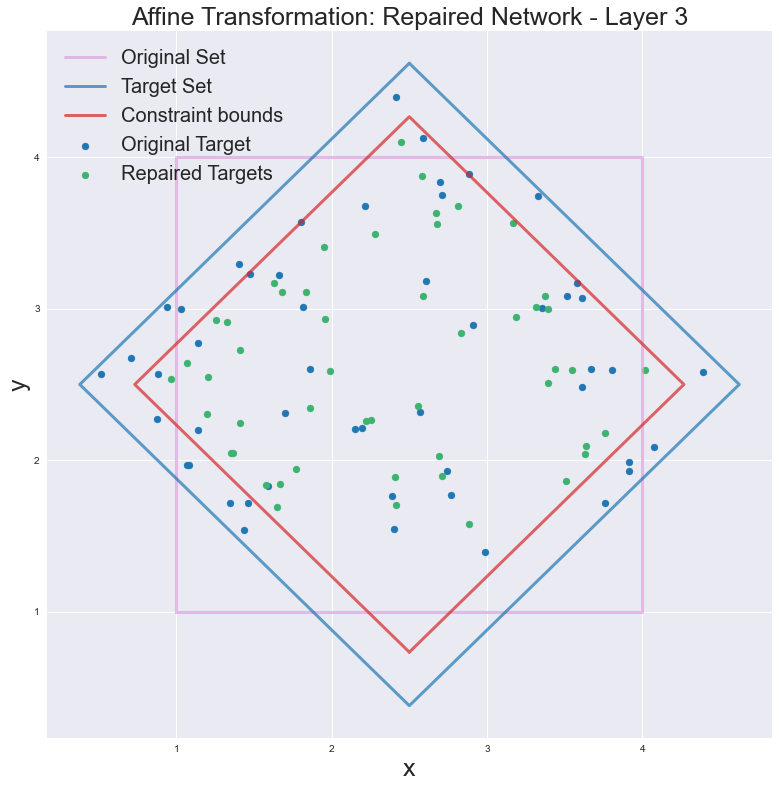

In [11]:
plt.rcParams["text.usetex"] = False
mpl.style.use("seaborn")
plt.rcParams["figure.figsize"] = (13,13)
x_poly_output_bound, y_poly_output_bound = poly_output.exterior.xy
x_poly_input_bound, y_poly_input_bound = poly_input.exterior.xy
x_poly_const_bound, y_poly_const_bound = poly_const.exterior.xy

## predicted output (training dataset)
plt.plot(
    x_poly_input_bound,
    y_poly_input_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_output_bound,
    y_poly_output_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.plot(
    x_poly_const_bound,
    y_poly_const_bound,
    color="tab:red",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Constraint bounds",
)
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    color="tab:blue",
    label="Original Target",
)
y_predict_train = out_model.predict(x_test)
plt.scatter(
    y_predict_train[:, 0],
    y_predict_train[:, 1],
    color="mediumseagreen",
    label="Repaired Targets",
)
plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(f"Affine Transformation: Repaired Network - Layer {layer_to_repair}", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()

#### Reset and Repair Another Layer
To evaluate network repair on another layer, we can use the `reset` method to first rest the repaired model to the original one. Then, perform `compile` and `repair` again. In the code below, we first reset the model then perform the repair on the first layer.

**Note**: sequential repair can be performed by performing `compile` and `repair` on another layer without `reset`.

In [12]:
# reset model
repair_obj.reset()

# compile the repair model for the first layer
layer_to_repair = 1    # specifying the last layer
max_weight_bound = 5   # specifying the upper bound of weights error
cost_weights = np.array([1.0, 1.0]) # cost weights
repair_obj.compile(
    x_repair,
    y_repair,
    layer_to_repair,
    output_constraint_list=output_constraint_list,
    cost_weights=cost_weights,
    max_weight_bound=max_weight_bound,
    output_bounds=(0.,4.5),
)

# setup directory to store the repaired model
if not os.path.exists(path_write):
    os.makedirs(path_write + f"/model_layer_{layer_to_repair}")

# specify options
options = Options(
    "gdp.bigm",
    "gurobi",
    "python",
    "keras",
    {
        "timelimit": 3600,
        "mipgap": 0.001,
        "mipfocus": 2,
        "improvestarttime": 3300,
        "logfile": path_write
        + f"/logs/opt_log_layer{layer_to_repair}.log",
    },
)

# repair the network
out_model = repair_obj.repair(options)

# store the modeled MIP and parameters
repair_obj.summary(direc=path_write + "/summary")

# store the repaired model
keras.models.save_model(
    out_model,
    path_write + f"/model_layer_{layer_to_repair}",
    overwrite=True,
    include_optimizer=False,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

Activating mid layer
Set parameter TimeLimit to value 3600
Set parameter MIPGap to value 0.001
Set parameter MIPFocus to value 2
Set parameter ImproveStartTime to value 3300
Set parameter LogFile to value "/Users/keyvanmajd/Documents/NNRepLayer_v2/demos/Affine Transform Demo Tensorflow/repair_net/logs/opt_log_layer1.log"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 11024 rows, 6613 columns and 25048 nonzeros
Model fingerprint: 0xb71682d8
Model has 601 quadratic objective terms
Variable types: 3013 continuous, 3600 integer (3600 binary)
Coefficient statistics:
  Matrix range     [4e-02, 4e+00]
  Objective range  [5e-03, 4e-02]
  QObjective range [1e-02, 2e+00]
  Bounds range     [1e+00, 6e+00]
  RHS range        [5e-02, 5e+00]
Presolve removed 6800 rows and 3200 columns
Presolve time: 0.16s
Presolved: 4224 rows, 3413 columns, 14048 nonzeros
Presolved model has 601 quadratic o

The following plot shows the outputs of repaired model on testing data set. As illustrated, the targets are repaired to stay inside the constraint bounds.

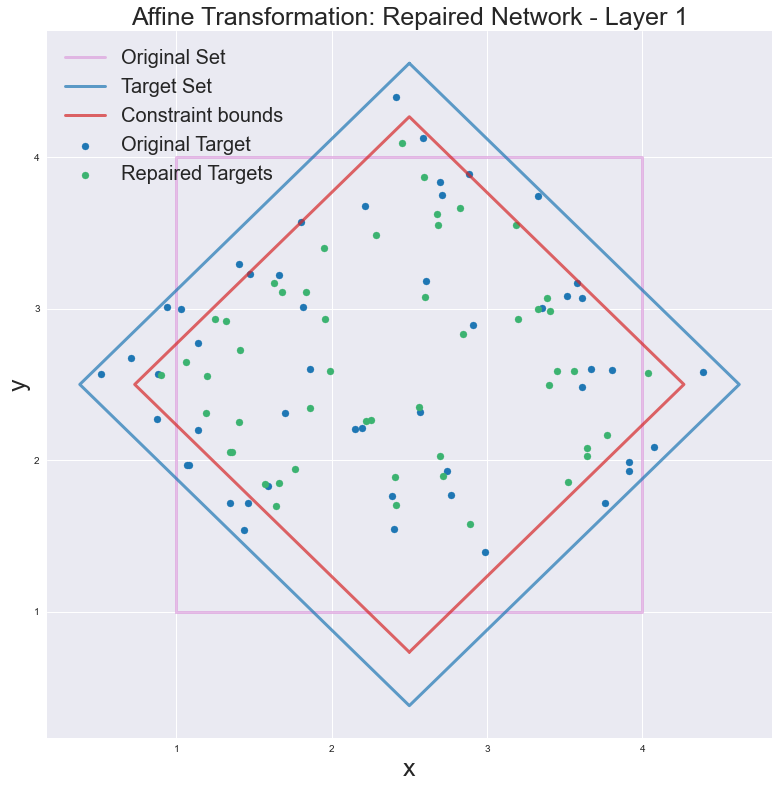

In [13]:
plt.rcParams["text.usetex"] = False
mpl.style.use("seaborn")
plt.rcParams["figure.figsize"] = (13,13)
x_poly_output_bound, y_poly_output_bound = poly_output.exterior.xy
x_poly_input_bound, y_poly_input_bound = poly_input.exterior.xy
x_poly_const_bound, y_poly_const_bound = poly_const.exterior.xy

## predicted output (training dataset)
plt.plot(
    x_poly_input_bound,
    y_poly_input_bound,
    color="plum",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Original Set",
)
plt.plot(
    x_poly_output_bound,
    y_poly_output_bound,
    color="tab:blue",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Target Set",
)
plt.plot(
    x_poly_const_bound,
    y_poly_const_bound,
    color="tab:red",
    alpha=0.7,
    linewidth=3,
    solid_capstyle="round",
    zorder=2,
    label="Constraint bounds",
)
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    color="tab:blue",
    label="Original Target",
)
y_predict_train = out_model.predict(x_test)
plt.scatter(
    y_predict_train[:, 0],
    y_predict_train[:, 1],
    color="mediumseagreen",
    label="Repaired Targets",
)
plt.legend(loc="upper left", frameon=False, fontsize=20)
plt.title(f"Affine Transformation: Repaired Network - Layer {layer_to_repair}", fontsize=25)
plt.xlabel("x", fontsize=25)
plt.ylabel("y", fontsize=25)
plt.show()